# Simulation-based inference with ACE
## OUP task

To run this evaluation notebook, please move the notebook to the outside folder under `amortized-conditioning-engine/`, we saved the trained models under `results/oup` for standard task and `results/oup_pi` for ACE with prior injection.

In [29]:
import sys
import os
import hydra
import matplotlib.pyplot as plt
import torch
from hydra import initialize, compose
from src.model.base import BaseTransformer
from src.dataset.sampler_joint import Sampler
from src.dataset.sampler_twoway import Sampler as Sampler_base
from src.dataset.sbi.oup import OUP, OUPOnlineAll, OUPOnlineAllSamePrior

import pickle
import seaborn as sns
import sbi
from sbi.utils.torchutils import *
from sbi.utils import process_prior
from sbi.utils.user_input_checks import *
from scipy.interpolate import make_interp_spline, BSpline
from sbi_demo_utils import *
import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

update_plot_style()

plt.rcParams['text.latex.preamble'] = r'\usepackage{times}'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
class OUP_npe(object):
    def __init__(self):
        self.prior = [Uniform(torch.zeros(1), 2 * torch.ones(1)),
                      Uniform(-2 * torch.ones(1), 2 * torch.ones(1))]

    def sample_theta(self, size):
        theta_1 = self.prior[0].sample(size).reshape(-1, 1)
        theta_2 = self.prior[1].sample(size).reshape(-1, 1)

        return torch.cat([theta_1, theta_2], dim=1)

    def __call__(self, thetas):
        num_points= 25
        theta_1 = thetas[0]
        theta_2 = thetas[1]
        theta_2_exp = torch.exp(theta_2)

        dt = 0.2
        X = torch.zeros(num_points)
        X[0] = 10

        w = torch.normal(0., 1., size=([num_points]))

        for t in range(num_points - 1):
            mu, sigma = theta_1 * (theta_2_exp - X[t]) * dt, 0.5 * (dt ** 0.5) * w[t]
            X[t + 1] = X[t] + mu + sigma

        return X

In [4]:
path = "results/oup/"
cfg_twoway, model_twoway = load_config_and_model(path=path, ckpt_name="ckpt_1.tar")

In [37]:
batch_size = 100
dataset = OUP(x_file="data/x_oup_10000.pt",
              theta_file="data/theta_oup_10000.pt",
              order="fixed",
              batch_size=batch_size)

sampler = Sampler_base(problem=dataset, 
                        batch_size=batch_size,
                        num_ctx=25, # check
                        num_latent=2, 
                        min_num_points=12, 
                        max_num_points=13,
                        n_total_points=25,
                        ctx_tar_sampler="predict_latents_fixed")

eval_set = sampler.sample()

out_twoway = model_twoway.forward(eval_set, predict=True)

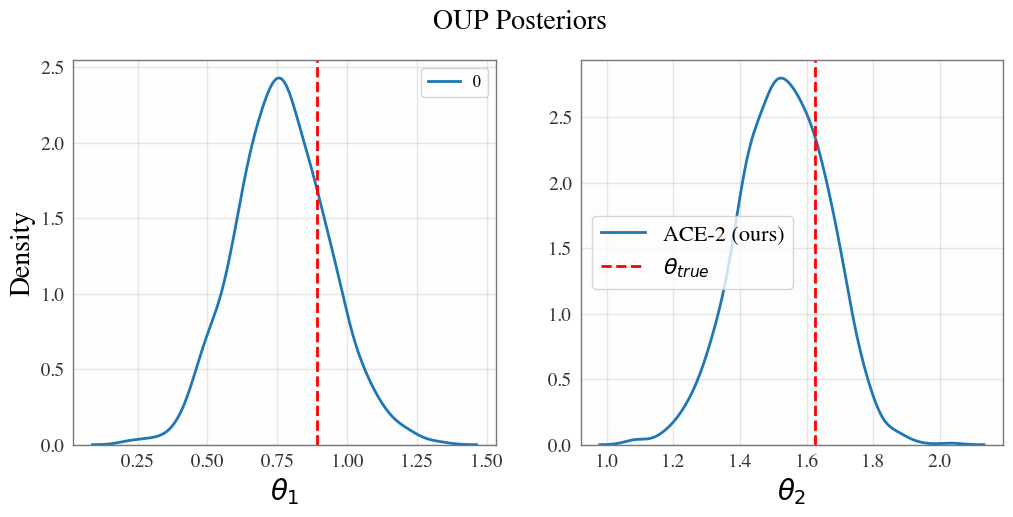

In [38]:
seed = 7

plt.figure(figsize=[12,5])
plt.suptitle(f"OUP Posteriors ", size=20)
plt.subplot(1, 2, 1)

sns.kdeplot(out_twoway.samples[seed, 0, :], color = "C2", linewidth = 2, linestyle = "solid", label = "ACE-2 (ours)")
plt.axvline(x=eval_set.yt[seed, 0].detach().numpy(), color='r', linestyle='--', linewidth=2, label='$\\theta_{true}$')
# plt.xlim(0, 2)
plt.xlabel("$\\theta_1$", fontsize = 20)
plt.ylabel("Density", fontsize=20)
plt.grid()

plt.subplot(1, 2, 2)
sns.kdeplot(out_twoway.samples[seed, 1, :], color = "C2", linewidth = 2, linestyle = "solid", label = "ACE-2 (ours)")
plt.axvline(x=eval_set.yt[seed, 1].detach().numpy(), color='r', linestyle='--', linewidth=2, label='$\\theta_{true}$')
# plt.xlim(-2, 2)
plt.legend(fontsize=16, loc=0)
plt.xlabel("$\\theta_2$", fontsize = 20)
plt.ylabel(None)
plt.grid()
plt.show()

# Train NPE

In [309]:
x_npe = torch.load("data/x_oup_10000.pt")
theta_npe = torch.load("data/theta_oup_10000.pt")

simulator = OUP_npe()
prior = simulator.prior
prior, *_ = process_prior(prior)

# train 5 NPE
posterior_npe = []
for seed in range(5):
    posterior_npe.append(train_npe(prior, theta_npe, x_npe))

# train 5 NRE
posterior_nre = []
for seed in range(5):
    posterior_nre.append(train_nre(prior, theta_npe, x_npe))

# save trained NPE and NRE
save_dir = "data/npe_posteriors_oup"
for i, posterior in enumerate(posterior_npe):
    save_path = os.path.join(save_dir, f"posterior_npe_{i}.pkl")
    with open(save_path, "wb") as handle:
        pickle.dump(posterior, handle)

save_dir = "data/nre_posteriors_oup"
for i, posterior in enumerate(posterior_nre):
    save_path = os.path.join(save_dir, f"posterior_nre_{i}.pkl")
    with open(save_path, "wb") as handle:
        pickle.dump(posterior, handle)

 Training neural network. Epochs trained: 31

In [19]:
# load trained NPE and NRE
save_dir = "data/npe_posteriors_oup"
posterior_npe = []
for i in range(5):
    load_path = os.path.join(save_dir, f"posterior_npe_{i}.pkl")
    with open(load_path, "rb") as handle:
        posterior_npe.append(pickle.load(handle))

save_dir = "data/nre_posteriors_oup"
posterior_nre = []
for i in range(5):
    load_path = os.path.join(save_dir, f"posterior_nre_{i}.pkl")
    with open(load_path, "rb") as handle:
        posterior_nre.append(pickle.load(handle))

## Evaluation of latents

In [20]:
n_runs = 5
batch_size = 100
dataset = OUPOnlineAll(order="fixed")

num_ctx_for_ppd = 12

# define sampler
sampler_joint = Sampler(problem=dataset, 
                        batch_size=batch_size,
                        num_latent=2, 
                        min_num_points=num_ctx_for_ppd, 
                        max_num_points=num_ctx_for_ppd+1)

eval_set_oneway, eval_set_twoway, eval_set_pi_twoway_narrow, eval_set_pi_twoway_wide = sampler_joint.sample_all_bin()

In [262]:
# save eval sets for posterior inference
data_dir = "data/eval_sets_oup"

torch.save(eval_set_oneway, os.path.join(data_dir, "eval_set_oneway.pt"))
torch.save(eval_set_twoway, os.path.join(data_dir, "eval_set_twoway.pt"))
torch.save(eval_set_pi_twoway_narrow, os.path.join(data_dir, "eval_set_pi_twoway_narrow.pt"))
torch.save(eval_set_pi_twoway_wide, os.path.join(data_dir, "eval_set_pi_twoway_wide.pt"))

In [21]:
# load eval sets for posterior inference
data_dir = "data/eval_sets_oup"

eval_set_oneway = torch.load(os.path.join(data_dir, "eval_set_oneway.pt"))
eval_set_twoway = torch.load(os.path.join(data_dir, "eval_set_twoway.pt"))
eval_set_pi_twoway_narrow = torch.load(os.path.join(data_dir, "eval_set_pi_twoway_narrow.pt"))
eval_set_pi_twoway_wide = torch.load(os.path.join(data_dir, "eval_set_pi_twoway_wide.pt"))

In [22]:
n_runs = 5

# go first with NPE as it takes some time
all_log_probs_npe = np.zeros(5)
all_rmse_npe = np.zeros(5)

for seed in range(n_runs):
    
    log_probs_npe = torch.zeros([batch_size])
    for i in range(batch_size):
        log_probs_npe[i] = posterior_npe[seed].log_prob(theta=eval_set_oneway.yt[i].reshape(-1, 2), x=eval_set_oneway.yc[i].reshape(-1, 25))
    all_log_probs_npe[seed] = log_probs_npe.mean().numpy()

    rmse_npe = torch.zeros([batch_size])
    samples_npe_all = torch.empty([batch_size, 2, 100])
    for i in range(batch_size):
        samples_npe_all[i] = posterior_npe[seed].sample((100,), x=eval_set_oneway.yc[i].reshape(-1, 25), show_progress_bars=False).T
    all_rmse_npe[seed] = RMSE(eval_set_oneway.yt, samples_npe_all)

print(f"NPE Log probs mean: {all_log_probs_npe.mean().item()}")
print(f"NPE Log probs std: {all_log_probs_npe.std().item()}")

print(f"NPE RMSE mean: {all_rmse_npe.mean().item()}")
print(f"NPE RMSE std: {all_rmse_npe.std().item()}")

NPE Log probs mean: 1.0882389187812804
NPE Log probs std: 0.10363937113640699
NPE RMSE mean: 0.4751763939857483
NPE RMSE std: 0.009011641522300027


In [30]:
n_runs = 5

all_log_probs_nre = np.zeros(5)
all_rmse_nre = np.zeros(5)

for seed in range(n_runs):
    
    log_probs_nre = torch.zeros([batch_size])
    for i in range(batch_size):
        log_probs_nre[i] = posterior_nre[seed].log_prob(theta=eval_set_oneway.yt[i].reshape(-1, 2), x=eval_set_oneway.yc[i].reshape(-1, 25))
    all_log_probs_nre[seed] = log_probs_nre.mean().numpy()

    rmse_npe = torch.zeros([batch_size])
    samples_nre_all = torch.empty([batch_size, 2, 100])
    for i in range(batch_size):
        samples_nre_all[i] = posterior_nre[seed].sample((100,), x=eval_set_oneway.yc[i].reshape(-1, 25), show_progress_bars=False).T
    all_rmse_nre[seed] = RMSE(eval_set_oneway.yt, samples_nre_all)

print(f"NRE Log probs mean: {all_log_probs_nre.mean().item()}")
print(f"NRE Log probs std: {all_log_probs_nre.std().item()}")

print(f"NRE RMSE mean: {all_rmse_nre.mean().item()}")
print(f"NRE RMSE std: {all_rmse_nre.std().item()}")

NRE Log probs mean: 1.0678506374359131
NRE Log probs std: 0.1261805653706639
NRE RMSE mean: 0.48825448751449585
NRE RMSE std: 0.002987872214093405


In [23]:
all_log_probs_ace_oneway = np.zeros(5)
all_log_probs_ace_twoway = np.zeros(5)
all_log_probs_ace_twoway_pi_narrow = np.zeros(5)
all_log_probs_ace_twoway_pi_wide = np.zeros(5)

all_rmse_ace_oneway = np.zeros(5)
all_rmse_ace_twoway = np.zeros(5)
all_rmse_ace_twoway_pi_narrow = np.zeros(5)
all_rmse_ace_twoway_pi_wide = np.zeros(5)

for seed in range(n_runs):
    # two way baseline
    path = "results/oup/"
    cfg_twoway, model_twoway = load_config_and_model(path, "config.yaml", f"ckpt_{seed+1}.tar")
    out_twoway = model_twoway.forward(eval_set_twoway, predict=True)
    samples_twoway = out_twoway.samples
    log_probs_twoway = -out_twoway.losses.sum(dim=-1)
    all_log_probs_ace_twoway[seed] = log_probs_twoway.mean().detach().numpy()
    all_rmse_ace_twoway[seed] = RMSE(eval_set_oneway.yt, samples_twoway)
    
    # two way prior injection narrow
    path = "results/oup_pi/"
    cfg_twoway_pi, model_twoway_pi = load_config_and_model(path, "config.yaml", f"ckpt_{seed+1}.tar")
    out_twoway_pi_narrow = model_twoway_pi.forward(eval_set_pi_twoway_narrow, predict=True)
    samples_twoway_pi_narrow = out_twoway_pi_narrow.samples
    log_probs_twoway_pi_narrow = -out_twoway_pi_narrow.losses.sum(dim=-1)
    all_log_probs_ace_twoway_pi_narrow[seed] = log_probs_twoway_pi_narrow.mean().detach().numpy()
    all_rmse_ace_twoway_pi_narrow[seed] = RMSE(eval_set_oneway.yt, samples_twoway_pi_narrow)

    # two way prior injection wide
    out_twoway_pi_wide = model_twoway_pi.forward(eval_set_pi_twoway_wide, predict=True)
    samples_twoway_pi_wide = out_twoway_pi_wide.samples
    log_probs_twoway_pi_wide = -out_twoway_pi_wide.losses.sum(dim=-1)
    all_log_probs_ace_twoway_pi_wide[seed] = log_probs_twoway_pi_wide.mean().detach().numpy()
    all_rmse_ace_twoway_pi_wide[seed] = RMSE(eval_set_oneway.yt, samples_twoway_pi_wide)
    

print(f"ACE Log probs mean: {all_log_probs_ace_twoway.mean().item()}")
print(f"ACE Log probs std: {all_log_probs_ace_twoway.std().item()}")
print(f"ACE RMSE mean: {all_rmse_ace_twoway.mean().item()}")
print(f"ACE RMSE std: {all_rmse_ace_twoway.std().item()}")

print(f"ACE PI wide Log probs mean: {all_log_probs_ace_twoway_pi_wide.mean().item()}")
print(f"ACE PI wide Log probs std: {all_log_probs_ace_twoway_pi_wide.std().item()}")
print(f"ACE PI wide RMSE mean: {all_rmse_ace_twoway_pi_wide.mean().item()}")
print(f"ACE PI wide RMSE std: {all_rmse_ace_twoway_pi_wide.std().item()}")

print(f"ACE PI narrow Log probs mean: {all_log_probs_ace_twoway_pi_narrow.mean().item()}")
print(f"ACE PI narrow Log probs std: {all_log_probs_ace_twoway_pi_narrow.std().item()}")
print(f"ACE PI narrow RMSE mean: {all_rmse_ace_twoway_pi_narrow.mean().item()}")
print(f"ACE PI narrow RMSE std: {all_rmse_ace_twoway_pi_narrow.std().item()}")

ACE Log probs mean: 1.0341973543167113
ACE Log probs std: 0.022835678418125255
ACE RMSE mean: 0.4771988570690155
ACE RMSE std: 0.004051760264188919
ACE PI wide Log probs mean: 1.0535914421081543
ACE PI wide Log probs std: 0.017403300703595203
ACE PI wide RMSE mean: 0.43415645360946653
ACE PI wide RMSE std: 0.005615002970971585
ACE PI narrow Log probs mean: 1.438993263244629
ACE PI narrow Log probs std: 0.029557559324109577
ACE PI narrow RMSE mean: 0.268354332447052
ACE PI narrow RMSE std: 0.005117676556043314


In [265]:
# Posterior MMD
all_mmd_ace = np.zeros(5)
all_mmd_ace_pi_narrow = np.zeros(5)
all_mmd_ace_pi_wide = np.zeros(5)

for seed in range(n_runs):
    # two way baseline
    path = "results/oup/"
    cfg_twoway, model_twoway = load_config_and_model(path, "config.yaml", f"ckpt_{seed+1}.tar")
    out_twoway = model_twoway.forward(eval_set_twoway, predict=True)
    samples_twoway = out_twoway.samples
    mmd = 0
    for i in range(batch_size):
        mmd += float(MMD_unweighted(samples_twoway[i].T, eval_set_twoway.yt[i].T, lengthscale=1))
    all_mmd_ace[seed] = mmd / batch_size

    # two way prior injection narrow
    path = "results/oup_pi/"
    cfg_twoway_pi, model_twoway_pi = load_config_and_model(path, "config.yaml", f"ckpt_{seed+1}.tar")
    out_twoway_pi_narrow = model_twoway_pi.forward(eval_set_pi_twoway_narrow, predict=True)
    samples_twoway_pi_narrow = out_twoway_pi_narrow.samples
    mmd = 0
    for i in range(batch_size):
       mmd += float(MMD_unweighted(samples_twoway_pi_narrow[i, :, :].T, eval_set_pi_twoway_narrow.yt[i, :, :].T, lengthscale=1))
    all_mmd_ace_pi_narrow[seed] = mmd / batch_size

    # two way prior injection wide
    out_twoway_pi_wide = model_twoway_pi.forward(eval_set_pi_twoway_wide, predict=True)
    samples_twoway_pi_wide = out_twoway_pi_wide.samples
    mmd = 0
    for i in range(batch_size):
       mmd += float(MMD_unweighted(samples_twoway_pi_wide[i, :, :].T, eval_set_pi_twoway_wide.yt[i, :, :].T, lengthscale=1))
    all_mmd_ace_pi_wide[seed] = mmd / batch_size

print(f"ACE-2 Posterior MMD mean: {all_mmd_ace.mean().item()}")
print(f"ACE-2 Posterior MMD std: {all_mmd_ace.std().item()}")

print(f"ACE-2 Posterior PI wide MMD mean: {all_mmd_ace_pi_wide.mean().item()}")
print(f"ACE-2 Posterior PI wide MMD std: {all_mmd_ace_pi_wide.std().item()}")

print(f"ACE-2 Posterior PI narrow MMD mean: {all_mmd_ace_pi_narrow.mean().item()}")
print(f"ACE-2 Posterior PI narrow MMD std: {all_mmd_ace_pi_narrow.std().item()}")

ACE-2 Posterior MMD mean: 0.18481932115554808
ACE-2 Posterior MMD std: 0.003845587582595949
ACE-2 Posterior PI wide MMD mean: 0.15756873047351835
ACE-2 Posterior PI wide MMD std: 0.0033659789462288808
ACE-2 Posterior PI narrow MMD mean: 0.07208142828941345
ACE-2 Posterior PI narrow MMD std: 0.0031181343781883863


In [24]:
model_A_data = all_log_probs_npe
model_B_data = all_log_probs_ace_twoway

# Set parameters
n_data = len(model_A_data)  # Number of samples in the original data
n_bootstrap = int(1e5)  # Number of bootstrap resampling iterations
alpha = 0.05  # Significance level

# Calculate the median of the original data
mean_A = np.mean(model_A_data)
mean_B = np.mean(model_B_data)

print(f"Original mean of Model A: {mean_A}")
print(f"Original mean of Model B: {mean_B}")

# Initialize win counts
wins_A = 0
wins_B = 0

# Perform Bootstrap resampling
for _ in range(n_bootstrap):
    # Resample A with replacement and calculate the mean of the sampled data
    bootstrap_sample_A = np.random.choice(model_A_data, size=n_data, replace=True)
    mean_bootstrap_A = np.mean(bootstrap_sample_A)
    
    # Resample B with replacement and calculate the mean of the sampled data
    bootstrap_sample_B = np.random.choice(model_B_data, size=n_data, replace=True)
    mean_bootstrap_B = np.mean(bootstrap_sample_B)
    
    # Determine which model performs better and update win counts
    if mean_bootstrap_B > mean_bootstrap_A:
        wins_B += 1
    else:
        wins_A += 1

# Calculate the win percentage of Model B compared to Model A
win_percentage_B = wins_B / n_bootstrap

print(f"Win percentage of Model B: {win_percentage_B * 100:.2f}%")

# Determine statistical significance
if win_percentage_B < alpha:
    print("Model B is statistically significantly worse than Model A.")
else:
    print("There is no statistically significant difference between Model B and Model A")

Original mean of Model A: 1.0882389187812804
Original mean of Model B: 1.0341973543167113
Win percentage of Model B: 13.04%
There is no statistically significant difference between Model B and Model A


### Ablation - Gaussian head

In [30]:
all_log_probs_ace_twoway = np.zeros(5)

all_rmse_ace_twoway = np.zeros(5)

for seed in range(n_runs):
    # two way baseline
    path = "results/oup_gaussian_head/"
    cfg_twoway, model_twoway = load_config_and_model(path, "config.yaml", f"ckpt_{seed+1}.tar")

    out_twoway = model_twoway.forward(eval_set_twoway, predict=True)
    samples_twoway_gaussian = out_twoway.samples.squeeze(-1)
    log_probs_twoway = -out_twoway.losses.sum(dim=-1)
    all_log_probs_ace_twoway[seed] = log_probs_twoway.mean().detach().numpy()
    all_rmse_ace_twoway[seed] = RMSE(eval_set_oneway.yt, samples_twoway_gaussian)
    

print(f"ACE Log probs mean: {all_log_probs_ace_twoway.mean().item()}")
print(f"ACE Log probs std: {all_log_probs_ace_twoway.std().item()}")
print(f"ACE RMSE mean: {all_rmse_ace_twoway.mean().item()}")
print(f"ACE RMSE std: {all_rmse_ace_twoway.std().item()}")

ACE Log probs mean: 0.8985823392868042
ACE Log probs std: 0.007564382820029457
ACE RMSE mean: 0.4789269983768463
ACE RMSE std: 0.0027669225779382977


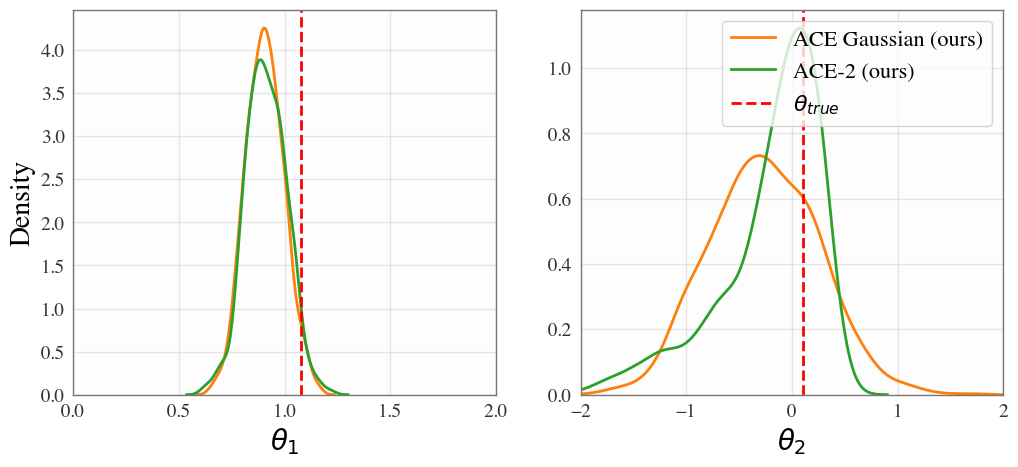

In [32]:
seed = 26

plt.figure(figsize=[12,5])
plt.subplot(1, 2, 1)

sns.kdeplot(samples_twoway_gaussian[seed, 0, :], color = "C1", linewidth = 2, linestyle = "solid", label = "ACE Gaussian (ours)")
sns.kdeplot(samples_twoway[seed, 0, :], color = "C2", linewidth = 2, linestyle = "solid", label = "ACE-2 (ours)")
plt.axvline(x=eval_set_oneway.yt[seed, 0].detach().numpy(), color='r', linestyle='--', linewidth=2, label='$\\theta_{true}$')
plt.xlim(0, 2)
plt.xlabel("$\\theta_1$", fontsize = 20)
plt.ylabel("Density", fontsize=20)
plt.grid()

plt.subplot(1, 2, 2)
sns.kdeplot(samples_twoway_gaussian[seed, 1, :], color = "C1", linewidth = 2, linestyle = "solid", label = "ACE Gaussian (ours)")
sns.kdeplot(samples_twoway[seed, 1, :], color = "C2", linewidth = 2, linestyle = "solid", label = "ACE-2 (ours)")
plt.axvline(x=eval_set_oneway.yt[seed, 1].detach().numpy(), color='r', linestyle='--', linewidth=2, label='$\\theta_{true}$')
plt.xlim(-2, 2)
plt.legend(fontsize=16, loc=0)
plt.xlabel("$\\theta_2$", fontsize = 20)
plt.ylabel(None)
plt.grid()
plt.show()

## Evaluation of data

In [33]:
sampling_way = 3
eval_set_ppd, eval_set_ppd_pi_narrow, eval_set_ppd_pi_wide = sampler_joint.sample_ppd(sampling_way, know_theta=False)

In [295]:
# save eval sets for data prediction
data_dir = "data/eval_sets_ppd_oup"

torch.save(eval_set_ppd, os.path.join(data_dir, "eval_set_ppd.pt"))
torch.save(eval_set_ppd_pi_narrow, os.path.join(data_dir, "eval_set_ppd_pi_narrow.pt"))
torch.save(eval_set_ppd_pi_wide, os.path.join(data_dir, "eval_set_ppd_pi_wide.pt"))

In [34]:
# load eval sets for posterior inference
data_dir = "data/eval_sets_ppd_oup"

eval_set_ppd = torch.load(os.path.join(data_dir, "eval_set_ppd.pt"))
eval_set_ppd_pi_narrow = torch.load(os.path.join(data_dir, "eval_set_ppd_pi_narrow.pt"))
eval_set_ppd_pi_wide = torch.load(os.path.join(data_dir, "eval_set_ppd_pi_wide.pt"))

In [35]:
all_mmd_ppd_ace = np.zeros(5)
all_mmd_ppd_ace_pi_narrow = np.zeros(5)
all_mmd_ppd_ace_pi_wide = np.zeros(5)

for seed in range(n_runs):
    # two way baseline
    path = "results/oup/"
    cfg_twoway, model_twoway = load_config_and_model(path, "config.yaml", f"ckpt_{seed+1}.tar")
    out_ppd_twoway = model_twoway.forward(eval_set_ppd, predict=True)
    samples_ppd_twoway = out_ppd_twoway.samples
    mmd = 0
    for i in range(batch_size):
        mmd += float(MMD_unweighted(samples_ppd_twoway[i].T, eval_set_ppd.yt[i].T, lengthscale=1))
    all_mmd_ppd_ace[seed] = mmd / batch_size

    # two way prior injection narrow
    path = "results/oup_pi/"
    cfg_twoway_pi, model_twoway_pi = load_config_and_model(path, "config.yaml", f"ckpt_{seed+1}.tar")
    out_ppd_twoway_pi_narrow = model_twoway_pi.forward(eval_set_ppd_pi_narrow, predict=True)
    samples_ppd_pi_twoway_narrow = out_ppd_twoway_pi_narrow.samples
    mmd = 0
    for i in range(batch_size):
       mmd += float(MMD_unweighted(samples_ppd_pi_twoway_narrow[i, :-2, :].T, eval_set_ppd_pi_narrow.yt[i, :-2, :].T, lengthscale=1))
    all_mmd_ppd_ace_pi_narrow[seed] = mmd / batch_size

    # two way prior injection wide
    out_ppd_twoway_pi_wide = model_twoway_pi.forward(eval_set_ppd_pi_wide, predict=True)
    samples_ppd_pi_twoway_wide = out_ppd_twoway_pi_wide.samples
    mmd = 0
    for i in range(batch_size):
       mmd += float(MMD_unweighted(samples_ppd_pi_twoway_wide[i, :-2, :].T, eval_set_ppd_pi_wide.yt[i, :-2, :].T, lengthscale=1))
    all_mmd_ppd_ace_pi_wide[seed] = mmd / batch_size

print(f"ACE-2 PPD MMD mean: {all_mmd_ppd_ace.mean().item()}")
print(f"ACE-2 PPD MMD std: {all_mmd_ppd_ace.std().item()}")

print(f"ACE-2 PPD PI wide MMD mean: {all_mmd_ppd_ace_pi_wide.mean().item()}")
print(f"ACE-2 PPD PI wide MMD std: {all_mmd_ppd_ace_pi_wide.std().item()}")

print(f"ACE-2 PPD PI narrow MMD mean: {all_mmd_ppd_ace_pi_narrow.mean().item()}")
print(f"ACE-2 PPD PI narrow MMD std: {all_mmd_ppd_ace_pi_narrow.std().item()}")

ACE-2 PPD MMD mean: 0.5148750134706497
ACE-2 PPD MMD std: 0.0017053846122182482
ACE-2 PPD PI wide MMD mean: 0.37348557877540584
ACE-2 PPD PI wide MMD std: 0.0009386092335667993
ACE-2 PPD PI narrow MMD mean: 0.35155410706996915
ACE-2 PPD PI narrow MMD std: 0.002358023088879279


In [36]:
all_mmd_ppd_ace = np.zeros(5)

for seed in range(n_runs):
    # two way baseline
    path = "results/oup_gaussian_head/"
    cfg_twoway, model_twoway = load_config_and_model(path, "config.yaml", f"ckpt_{seed+1}.tar")
    out_ppd_twoway = model_twoway.forward(eval_set_ppd, predict=True)
    samples_ppd_twoway = out_ppd_twoway.samples.squeeze(-1)
    mmd = 0
    for i in range(batch_size):
        mmd += float(MMD_unweighted(samples_ppd_twoway[i].T, eval_set_ppd.yt[i].T, lengthscale=1))
    all_mmd_ppd_ace[seed] = mmd / batch_size


print(f"ACE-2 PPD MMD mean: {all_mmd_ppd_ace.mean().item()}")
print(f"ACE-2 PPD MMD std: {all_mmd_ppd_ace.std().item()}")

ACE-2 PPD MMD mean: 0.5170286033153534
ACE-2 PPD MMD std: 0.001642690736058822


In [301]:
torch.save(all_log_probs_npe, "results/metrics/oup_log_probs_npe.npy")
torch.save(all_log_probs_nre, "results/metrics/oup_log_probs_nre.npy")
torch.save(all_log_probs_ace_twoway, "results/metrics/oup_log_probs_ace.npy")
torch.save(all_log_probs_ace_twoway_pi_narrow, "results/metrics/oup_log_probs_ace_narrow.npy")
torch.save(all_log_probs_ace_twoway_pi_wide, "results/metrics/oup_log_probs_ace_wide.npy")

torch.save(all_rmse_npe, "results/metrics/oup_rmse_npe.npy")
torch.save(all_rmse_nre, "results/metrics/oup_rmse_nre.npy")
torch.save(all_rmse_ace_twoway, "results/metrics/oup_rmse_ace.npy")
torch.save(all_rmse_ace_twoway_pi_narrow, "results/metrics/oup_rmse_ace_narrow.npy")
torch.save(all_rmse_ace_twoway_pi_wide, "results/metrics/oup_rmse_ace_wide.npy")

torch.save(all_mmd_ppd_ace, "results/metrics/oup_mmd_ace.npy")
torch.save(all_mmd_ppd_ace_pi_narrow, "results/metrics/oup_mmd_ace_narrow.npy")
torch.save(all_mmd_ppd_ace_pi_wide, "results/metrics/oup_mmd_ace_wide.npy")

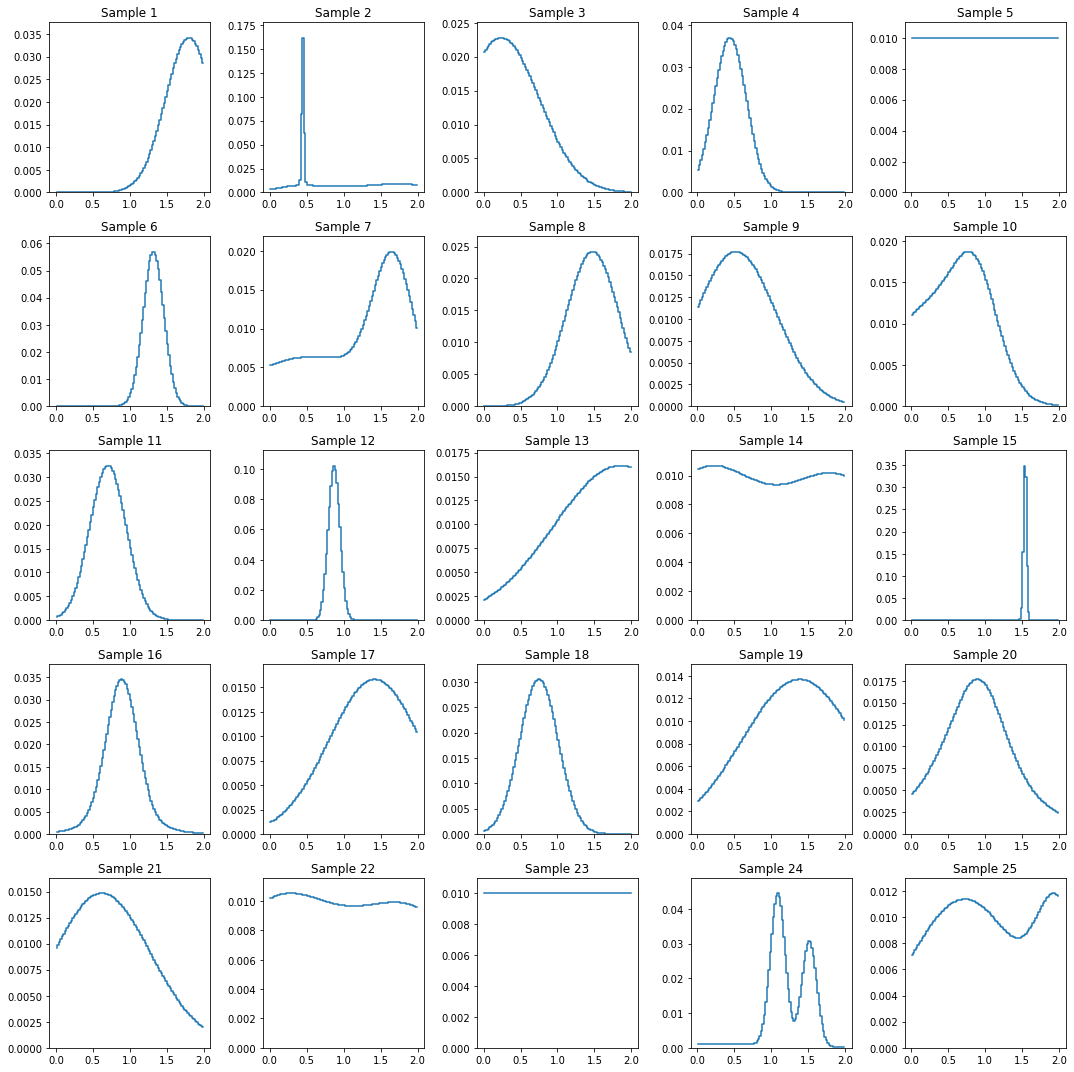

In [384]:
from torch.distributions import Normal, Geometric, Dirichlet, LogNormal, Categorical, Uniform

class Sampler:
    def __init__(self, num_bins, bin_start, bin_end):
        self.num_bins = num_bins
        self.bin_start = bin_start
        self.bin_end = bin_end
        self.mean_prior =  Uniform(torch.zeros(1), 2 * torch.ones(1))
        self.std_prior = Uniform(0.01 * torch.ones(1), 1 * torch.ones(1))

    def sample_uniform_bin_weights(self):
        """
        Sample uniform bin weights where all bins have equal probability.

        Returns:
            torch.Tensor: Uniform bin weights.
        """
        bin_probs = torch.ones(self.num_bins) / self.num_bins
        return bin_probs
    
    def sample_mixture_gaussian_components(self):
        K = Geometric(0.4).sample().int().item() + 1
        component_type = Categorical(torch.tensor([1/3, 1/3, 1/3])).sample().item()
        
        means = self.mean_prior.sample((K,)).squeeze()
        stds = self.std_prior.sample((K,)).squeeze()

        if component_type == 0:
            means.fill_(self.mean_prior.sample().item())
        elif component_type == 1:
            stds.fill_(self.std_prior.sample().item())
        
        weights = Dirichlet(torch.ones(K)).sample()
        return means.reshape(-1), stds.reshape(-1), weights.reshape(-1)

    def sample_from_dirichlet(self):
        alpha0 = LogNormal(torch.log(torch.tensor(1.0)), 2).sample()
        bin_weights = Dirichlet(torch.full((self.num_bins,), alpha0)).sample()
        return bin_weights

    def sample_bin_weights(self):
        if torch.rand(1) < 0.8:
            means, stds, weights = self.sample_mixture_gaussian_components()
            bin_probs = torch.zeros(self.num_bins)
            linspace = torch.linspace(self.bin_start, self.bin_end, self.num_bins + 1)
            for mean, std, weight in zip(means, stds, weights):
                cdf_right = Normal(mean, std).cdf(linspace[1:])
                cdf_left = Normal(mean, std).cdf(linspace[:-1])
                bin_probs += weight * (cdf_right - cdf_left)
        else:
            bin_probs = self.sample_uniform_bin_weights()
        
        bin_probs /= bin_probs.sum()
        return bin_probs

    def sample_from_bin_distribution(self, bin_weights):
        bins_indices = Categorical(bin_weights).sample().item()
        bin_edges = torch.linspace(self.bin_start, self.bin_end, self.num_bins + 1)
        lower_edge = bin_edges[bins_indices]
        upper_edge = bin_edges[bins_indices + 1]
        random_value = Uniform(lower_edge, upper_edge).sample()
        return random_value, bins_indices


sampler = Sampler(num_bins=100, bin_start=0, bin_end=2)


fig, axs = plt.subplots(5, 5, figsize=(15, 15))
for i in range(5):
    for j in range(5):
        bin_weights = sampler.sample_bin_weights()
        random_value, selected_bin = sampler.sample_from_bin_distribution(bin_weights)
        
        bin_edges = np.linspace(sampler.bin_start, sampler.bin_end, sampler.num_bins + 1)
        bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
        axs[i, j].plot(bin_centers, bin_weights.numpy(), drawstyle='steps-mid')
        axs[i, j].set_title(f"Sample {i*5+j+1}")
        axs[i, j].set_ylim(0, max(bin_weights.numpy())*1.1)

plt.tight_layout()
plt.savefig("figures/prior_samples.pdf")
plt.show()
